In [3]:
# Required Imports
import os, json, time
from pyproj import Transformer, Geod    
from wildfire.Reader import Reader as WFReader
import geojson
import pandas as pd
import matplotlib.pyplot as plt

/var/folders/js/_m5r698x29j4dvr0w18h6jdm0000gn/T/ipykernel_32560/3262185334.py:6: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [4]:
with open('intermediate_file_paths.json') as output_path_file:
    output_paths = json.load(output_path_file)


SI_PER_YEAR_INPUT_PATH = output_paths.get('stage1_si_per_year_csv')
EPA_AQI_PER_YEAR_INPUT_PATH = output_paths.get('stage1_epa_aqi_per_year_csv')
FIRE_INPUT_PATH = output_paths.get('stage0_fire_json')

# Question 1

In [62]:
with open(FIRE_INPUT_PATH) as fire_file:
    fire_data_for_hist = geojson.load(fire_file)

In [63]:
fire_distances = []

for feature in fire_data_for_hist['features']:

    dist_from_memphis = feature.get('attributes', {}).get('distance')
    fire_distances.append(dist_from_memphis)

In [64]:
# Convert fire_distances to a DataFrame for easier analysis and plotting
distances_df = pd.DataFrame(fire_distances, columns=['distance_miles'])

# Calculate summary statistics
distance_summary = distances_df['distance_miles'].describe()
print("Distance Summary Statistics:")
print(distance_summary)

Distance Summary Statistics:
count    101906.000000
mean       1059.860947
std         526.912300
min           5.992876
25%         572.452124
50%        1127.416618
75%        1561.397625
max        1799.999235
Name: distance_miles, dtype: float64


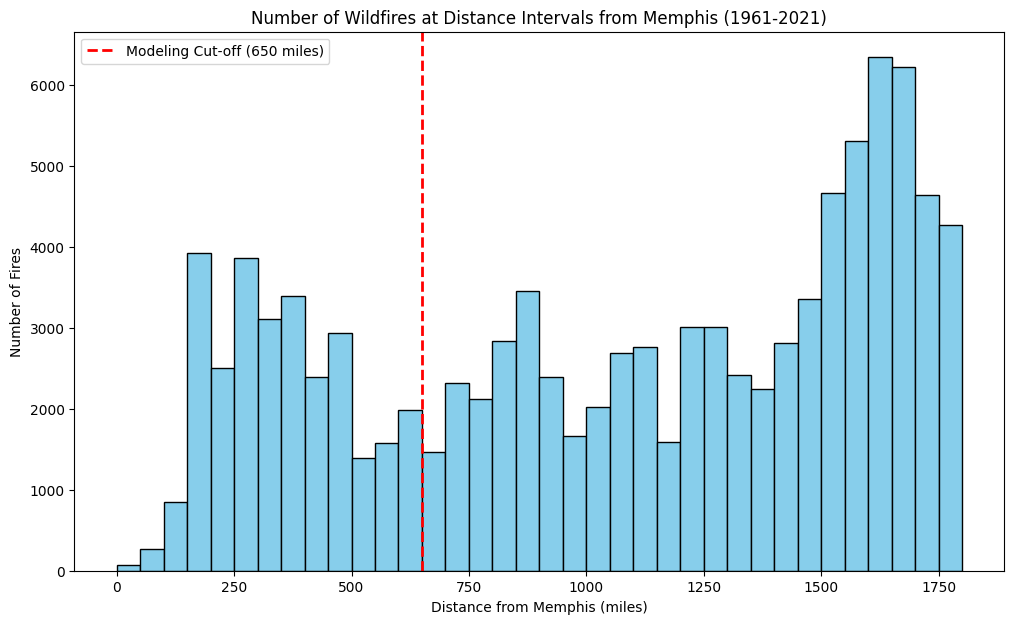

In [65]:
# Define the bin edges for every 50-mile interval up to 1800 miles
bins = list(range(0, 1801, 50))  # Creates bins: 0-50, 50-100, ..., up to 1750-1800

# Set the distance cut-off for modeling (replace with your specific cut-off if different)
modeling_distance_cutoff = 650

# Plot the histogram
plt.figure(figsize=(12, 7))
plt.hist(fire_distances, bins=bins, color='skyblue', edgecolor='black')
plt.axvline(x=modeling_distance_cutoff, color='red', linestyle='--', linewidth=2, label=f'Modeling Cut-off ({modeling_distance_cutoff} miles)')
plt.xlabel('Distance from Memphis (miles)')
plt.ylabel('Number of Fires')
plt.title('Number of Wildfires at Distance Intervals from Memphis (1961-2021)')
plt.legend()
plt.show()

## Question 2

In [81]:
per_year_df = pd.read_csv(SI_PER_YEAR_INPUT_PATH)

In [82]:
# Display the column headers and basic information for the politician dataset
print("\nPer Year Smoke Imact + Acres Burned - Column Headers:")
print(per_year_df.columns)

print("\nPer Year Smoke Imact + Acres Burned - Basic Info:")
print(per_year_df.info())

print("\nPer Year Smoke Imact + Acres Burned - First 5 Rows:")
print(per_year_df.head())


Per Year Smoke Imact + Acres Burned - Column Headers:
Index(['fire_year', 'total_amortized_smoke_impact', 'total_acres_burned',
       'scaled_smoke_impact'],
      dtype='object')

Per Year Smoke Imact + Acres Burned - Basic Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57 entries, 0 to 56
Data columns (total 4 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   fire_year                     57 non-null     int64  
 1   total_amortized_smoke_impact  57 non-null     float64
 2   total_acres_burned            57 non-null     float64
 3   scaled_smoke_impact           57 non-null     float64
dtypes: float64(3), int64(1)
memory usage: 1.9 KB
None

Per Year Smoke Imact + Acres Burned - First 5 Rows:
   fire_year  total_amortized_smoke_impact  total_acres_burned  \
0       1964                      0.000372           28.468121   
1       1965                      0.000591           43.781494   
2    

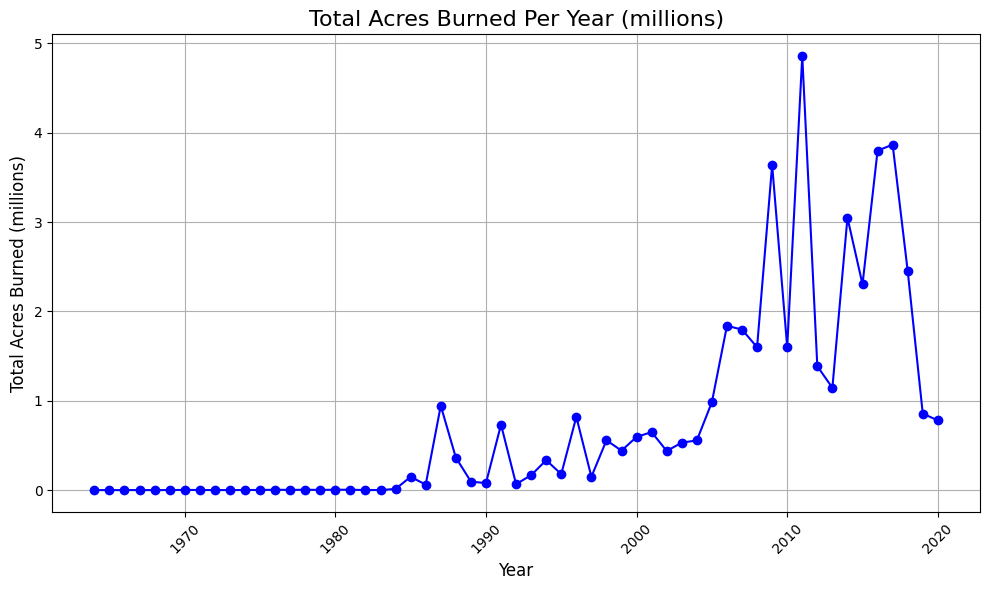

In [83]:
# Convert total acres burned to millions
per_year_df['total_acres_burned_millions'] = per_year_df['total_acres_burned'] / 1e6


# Plotting the time series of total acres burned per year in millions
plt.figure(figsize=(10, 6))

# Plot total acres burned (in millions) against the year
plt.plot(per_year_df['fire_year'], per_year_df['total_acres_burned_millions'], marker='o', linestyle='-', color='b')

# Adding title and labels
plt.title('Total Acres Burned Per Year (millions)', fontsize=16)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Total Acres Burned (millions)', fontsize=12)

# Rotate the x-axis labels for better readability
plt.xticks(rotation=45)

# Display the plot
plt.grid(True)
plt.tight_layout()
plt.show()


## Question 3

In [84]:
epa_aqi_df = pd.read_csv(EPA_AQI_PER_YEAR_INPUT_PATH)
si_per_year_df = pd.read_csv(SI_PER_YEAR_INPUT_PATH)

In [85]:
print(epa_aqi_df.head(5))

   year  site_code              site_name  pollutant_number  \
0  1972         21  Frayser Ozone Monitor             42101   
1  1972         21  Frayser Ozone Monitor             42602   
2  1972         21  Frayser Ozone Monitor             44201   
3  1973         21  Frayser Ozone Monitor             42101   
4  1973         21  Frayser Ozone Monitor             42602   

           pollutant_name  average_aqi  
0         Carbon monoxide    26.322581  
1  Nitrogen dioxide (NO2)    30.482759  
2                   Ozone    16.552083  
3         Carbon monoxide    35.275862  
4  Nitrogen dioxide (NO2)    23.161290  


In [86]:
annual_aqi_per_year_df = epa_aqi_df.groupby('year', as_index=False)['average_aqi'].mean()

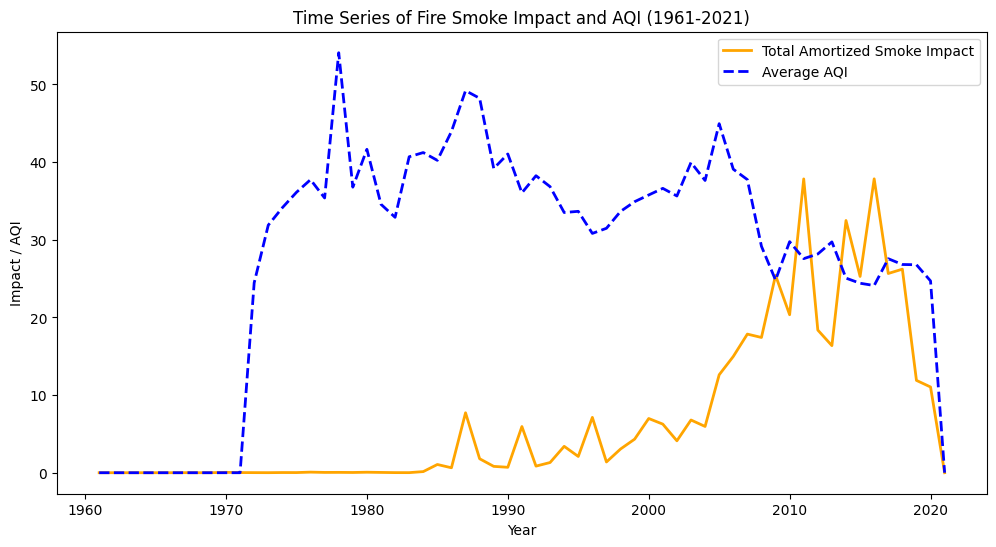

In [87]:
# Merge datasets on 'year' column
combined_df = pd.merge(si_per_year_df, annual_aqi_per_year_df, left_on='fire_year', right_on='year', how='outer')

# Create a DataFrame containing all years from 1961 to 2021
all_years_df = pd.DataFrame({'fire_year': range(1961, 2022)})

# Merge with all_years_df to include all years, filling missing values with zero
combined_df = pd.merge(all_years_df, combined_df, on='fire_year', how='left').fillna(0)

# Plotting
plt.figure(figsize=(12, 6))

# Plot Total Weighted Smoke Impact
plt.plot(combined_df['fire_year'], combined_df['total_amortized_smoke_impact'], label='Total Amortized Smoke Impact', color='orange', linewidth=2)

# Plot Average AQI
plt.plot(combined_df['fire_year'], combined_df['average_aqi'], label='Average AQI', color='blue', linestyle='--', linewidth=2)

# Labels and Title
plt.xlabel('Year')
plt.ylabel('Impact / AQI')
plt.title('Time Series of Fire Smoke Impact and AQI (1961-2021)')
plt.legend()


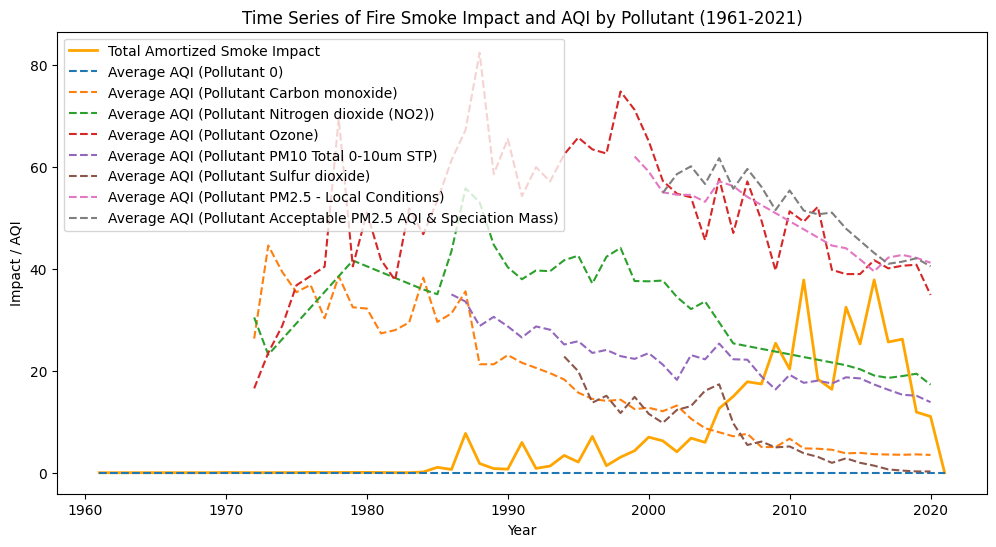

In [88]:
# Group AQI by pollutant and calculate the average AQI per pollutant per year
aqi_by_pollutant_df = epa_aqi_df.groupby(['year', 'pollutant_name'], as_index=False)['average_aqi'].mean()

# Merge datasets on 'year' column
combined_df_2 = pd.merge(si_per_year_df, aqi_by_pollutant_df, left_on='fire_year', right_on='year', how='outer')

# Create a DataFrame containing all years from 1961 to 2021
all_years_df = pd.DataFrame({'fire_year': range(1961, 2022)})

# Merge with all_years_df to include all years, filling missing values with zero
combined_df_3 = pd.merge(all_years_df, combined_df_2, on='fire_year', how='left').fillna(0)

# Plotting
plt.figure(figsize=(12, 6))

# Plot Total Weighted Smoke Impact
plt.plot(combined_df_3['fire_year'], combined_df_3['total_amortized_smoke_impact'], label='Total Amortized Smoke Impact', color='orange', linewidth=2)

# Plot Average AQI for each pollutant
for pollutant in combined_df_3['pollutant_name'].unique():
    # Filter the DataFrame for the current pollutant
    pollutant_data = combined_df_3[combined_df_3['pollutant_name'] == pollutant]
    plt.plot(
        pollutant_data['fire_year'], 
        pollutant_data['average_aqi'], 
        label=f'Average AQI (Pollutant {(pollutant)})', 
        linestyle='--', linewidth=1.5
    )

# Labels and Title
plt.xlabel('Year')
plt.ylabel('Impact / AQI')
plt.title('Time Series of Fire Smoke Impact and AQI by Pollutant (1961-2021)')
plt.legend()
plt.show()
